In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [1]:
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
os.chdir('..')
# os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [3]:
from fashion_recommendations.metrics.average_precision import mapk

In [4]:
pd.options.display.max_columns = None

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
articles_df = pd.read_csv(
    'data/articles.csv', 
    dtype={'article_id': str}, 
)
print(articles_df.shape)
articles_df.head()

(105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [9]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [12]:
for i in articles_df['detail_desc'].sample(n=5):
    print(i)

Calf-length trousers in woven fabric with a high waist, belt with a metal buckle, side pockets, zip fly and straight, wide legs.
Sleeveless, gently flared tunic in soft viscose jersey. Lined at the top.
Shaftless socks in a soft, fine-knit cotton blend.
5-pocket low-rise jeans in washed denim with hard-worn details, a button fly and slightly wider, tapered legs.
Double-layered hat in a soft, fine knit with embroidery on the turned-up hem and faux fur pompoms on top.


In [13]:
article_descriptions = articles_df['detail_desc'].to_list()
article_descriptions[:5]

['Jersey top with narrow shoulder straps.',
 'Jersey top with narrow shoulder straps.',
 'Jersey top with narrow shoulder straps.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.']

In [16]:
#Sentences are encoded by calling model.encode()
embeddings = model.encode(article_descriptions[0])

### Load transactions

In [7]:
train_set_orig = pd.read_csv('data/splits/train_subset.tsv', sep='\t', dtype={'article_id': str}, usecols=['t_dat', 'customer_id', 'article_id'])
print(train_set_orig.shape)
train_set_orig.head()

(588758, 3)


,t_dat,customer_id,article_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023
2,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0650193004
3,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0527687006
4,2018-09-20,02bfe1a5248beb9cd28ad4ac630a6d75e78d9a3e14551a...,0668767002


In [8]:
train_set_orig['t_dat'] = pd.to_datetime(train_set_orig['t_dat'])

In [9]:
end = train_set_orig['t_dat'].max()
endm1 = end - datetime.timedelta(days=7)

endm1, end

(Timestamp('2020-09-07 00:00:00'), Timestamp('2020-09-14 00:00:00'))

In [10]:
test_set = pd.read_csv('data/splits/test_subset.tsv', sep='\t', dtype={'article_id': str}, usecols=['t_dat', 'customer_id', 'article_id'])
print(test_set.shape)
test_set.head()

(32995, 3)


,t_dat,customer_id,article_id
0,2020-09-15,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007
1,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010
2,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010
3,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0610776105
4,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0929745001


In [11]:
test_set['customer_id'].nunique()

9208

In [12]:
train_set_orig['customer_id'].nunique()

9208

In [13]:
test_set.groupby('customer_id')['article_id'].count().describe()

count    9208.000000
mean        3.583297
std         3.604664
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        95.000000
Name: article_id, dtype: float64

In [14]:
train_set_orig.groupby('customer_id')['article_id'].count().describe()

count    9208.000000
mean       63.939835
std        78.250145
min         1.000000
25%        17.000000
50%        40.000000
75%        81.000000
max      1154.000000
Name: article_id, dtype: float64

In [15]:
train_set_orig[train_set_orig['t_dat'] > endm1].groupby('customer_id')['article_id'].count().describe()

count    1828.000000
mean        4.079869
std         4.488405
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        57.000000
Name: article_id, dtype: float64

In [16]:
train_set_orig[train_set_orig['t_dat'] > endm1]['customer_id'].nunique()

1828

### Top 10k items as candidates (across whole training period)

In [21]:
top_1k_articles = train_set_orig['article_id'].value_counts().head(1000).index.to_list()
top_1k_articles[:5]

['0706016001', '0706016002', '0372860001', '0610776002', '0759871002']

In [23]:
test_set_pred = test_set[['customer_id']].copy()
test_set_pred['join_key'] = 1

In [28]:
top_1k_articles_df = pd.DataFrame(top_1k_articles, columns=['article_id'])
top_1k_articles_df['join_key'] = 1

In [30]:
test_set_pred = test_set_pred.merge(top_1k_articles_df, on='join_key')

In [33]:
test_set_pred = test_set_pred.groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
test_set_pred.head()

,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0706016001, 0706016002, 0372860001, 061077600..."
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0706016001, 0706016002, 0372860001, 061077600..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0706016001, 0706016002, 0372860001, 061077600..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0706016001, 0706016002, 0372860001, 061077600..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0706016001, 0706016002, 0372860001, 061077600..."


In [35]:
test_set_pred.shape

(9208, 2)

In [36]:
test_set_act = test_set.groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
print(test_set_act.shape)
test_set_act.head()

(9208, 2)


,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[0794321007]
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0778745010, 0778745010, 0610776105, 092974500..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0855249006, 0822171001]"
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0920012003, 0572797002, 0572797002, 056860104..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0827968001, 0887757001, 0673677002, 079936500..."


In [38]:
compare = test_set_act.merge(test_set_pred, on='customer_id', suffixes=('_act', '_pred'))
compare.head()

,customer_id,article_id_act,article_id_pred
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[0794321007],"[0706016001, 0706016002, 0372860001, 061077600..."
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0778745010, 0778745010, 0610776105, 092974500...","[0706016001, 0706016002, 0372860001, 061077600..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0855249006, 0822171001]","[0706016001, 0706016002, 0372860001, 061077600..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0920012003, 0572797002, 0572797002, 056860104...","[0706016001, 0706016002, 0372860001, 061077600..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0827968001, 0887757001, 0673677002, 079936500...","[0706016001, 0706016002, 0372860001, 061077600..."


In [44]:
def precision(a: list, b: list):
    a = set(a)
    b = set(b)
    num_common = len(a.intersection(b))
    return num_common / len(a)

In [45]:
compare.apply(lambda x: precision(x['article_id_act'], x['article_id_pred']), axis=1).mean()

0.13838904109873365

### Top 10k items as candidates (since 2020)

In [322]:
end

Timestamp('2020-09-14 00:00:00')

In [361]:
top_1k_articles_since2020 = train_set_orig[train_set_orig['t_dat'] > '2020-09-01']['article_id'].value_counts().head(1000).index.to_list()
top_1k_articles_since2020[:5]

['0715255013', '0909370001', '0915526001', '0896152002', '0918522001']

In [362]:
len(set(top_1k_articles_since2020).intersection(set(top_1k_articles)))

150

In [363]:
test_set_pred = test_set[['customer_id']].copy()
test_set_pred['join_key'] = 1

In [364]:
top_1k_articles_df = pd.DataFrame(top_1k_articles_since2020, columns=['article_id'])
top_1k_articles_df['join_key'] = 1

In [365]:
test_set_pred = test_set_pred.merge(top_1k_articles_df, on='join_key')

In [366]:
test_set_pred = test_set_pred.groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
test_set_pred.head()

,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0715255013, 0909370001, 0915526001, 089615200..."
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0715255013, 0909370001, 0915526001, 089615200..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0715255013, 0909370001, 0915526001, 089615200..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0715255013, 0909370001, 0915526001, 089615200..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0715255013, 0909370001, 0915526001, 089615200..."


In [367]:
test_set_pred.shape

(9208, 2)

In [368]:
test_set_act = test_set.groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
print(test_set_act.shape)
test_set_act.head()

(9208, 2)


,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[0794321007]
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0778745010, 0778745010, 0610776105, 092974500..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0855249006, 0822171001]"
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0920012003, 0572797002, 0572797002, 056860104..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0827968001, 0887757001, 0673677002, 079936500..."


In [369]:
compare = test_set_act.merge(test_set_pred, on='customer_id', suffixes=('_act', '_pred'))
compare.head()

,customer_id,article_id_act,article_id_pred
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[0794321007],"[0715255013, 0909370001, 0915526001, 089615200..."
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0778745010, 0778745010, 0610776105, 092974500...","[0715255013, 0909370001, 0915526001, 089615200..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0855249006, 0822171001]","[0715255013, 0909370001, 0915526001, 089615200..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0920012003, 0572797002, 0572797002, 056860104...","[0715255013, 0909370001, 0915526001, 089615200..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0827968001, 0887757001, 0673677002, 079936500...","[0715255013, 0909370001, 0915526001, 089615200..."


In [370]:
def precision(a: list, b: list):
    a = set(a)
    b = set(b)
    num_common = len(a.intersection(b))
    return num_common / len(a)

In [371]:
compare.apply(lambda x: precision(x['article_id_act'], x['article_id_pred']), axis=1).mean()

0.3877335690720355

### Previously bought items as prediction

In [372]:
train_set_orig.sort_values(['customer_id', 't_dat'], inplace=True)

In [373]:
test_set_pred = train_set_orig.groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()

In [374]:
test_set_pred['article_id'] = test_set_pred['article_id'].apply(lambda x: x[-1000:])  # Take latest 1000

In [375]:
test_set_pred.head()

,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0663713001, 0541518023, 0663713001, 057802000..."
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0656491001, 0676573005, 0504154019, 068421000..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0573626001, 0688632001, 0569974001, 057000200..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0487932038, 0487932038, 0628458001, 068054200..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0201219001, 0322017003, 0156231001, 075475100..."


In [376]:
test_set_pred.shape

(9208, 2)

In [377]:
test_set_act = test_set.groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
print(test_set_act.shape)
test_set_act.head()

(9208, 2)


,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[0794321007]
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0778745010, 0778745010, 0610776105, 092974500..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0855249006, 0822171001]"
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0920012003, 0572797002, 0572797002, 056860104..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0827968001, 0887757001, 0673677002, 079936500..."


In [378]:
compare = test_set_act.merge(test_set_pred, on='customer_id', suffixes=('_act', '_pred'))
compare.head()

,customer_id,article_id_act,article_id_pred
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[0794321007],"[0663713001, 0541518023, 0663713001, 057802000..."
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0778745010, 0778745010, 0610776105, 092974500...","[0656491001, 0676573005, 0504154019, 068421000..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0855249006, 0822171001]","[0573626001, 0688632001, 0569974001, 057000200..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0920012003, 0572797002, 0572797002, 056860104...","[0487932038, 0487932038, 0628458001, 068054200..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0827968001, 0887757001, 0673677002, 079936500...","[0201219001, 0322017003, 0156231001, 075475100..."


In [379]:
def precision(a: list, b: list):
    a = set(a)
    b = set(b)
    num_common = len(a.intersection(b))
    return num_common / len(a)

In [380]:
compare.apply(lambda x: precision(x['article_id_act'], x['article_id_pred']), axis=1).mean()

0.05130355246528273

### Previous purchases and top items since 2020

In [381]:
test_set_pred = train_set_orig.groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
test_set_pred.head()

,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0663713001, 0541518023, 0663713001, 057802000..."
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0656491001, 0676573005, 0504154019, 068421000..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0573626001, 0688632001, 0569974001, 057000200..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0487932038, 0487932038, 0628458001, 068054200..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0201219001, 0322017003, 0156231001, 075475100..."


In [382]:
# Take latest 1000
test_set_pred['article_id'] = test_set_pred['article_id'].apply(lambda x: x[-1000:])

In [383]:
test_set_pred['number_of_prev'] = test_set_pred['article_id'].apply(len)

<AxesSubplot:>

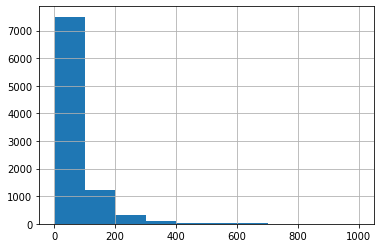

In [384]:
test_set_pred['number_of_prev'].hist()

In [385]:
test_set_pred['filler_articles'] = test_set_pred['number_of_prev'].apply(lambda x: top_1k_articles_since2020[:1000-x])
test_set_pred.head()

,customer_id,article_id,number_of_prev,filler_articles
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0663713001, 0541518023, 0663713001, 057802000...",17,"[0715255013, 0909370001, 0915526001, 089615200..."
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0656491001, 0676573005, 0504154019, 068421000...",48,"[0715255013, 0909370001, 0915526001, 089615200..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0573626001, 0688632001, 0569974001, 057000200...",55,"[0715255013, 0909370001, 0915526001, 089615200..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0487932038, 0487932038, 0628458001, 068054200...",12,"[0715255013, 0909370001, 0915526001, 089615200..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0201219001, 0322017003, 0156231001, 075475100...",23,"[0715255013, 0909370001, 0915526001, 089615200..."


In [386]:
# Concat lists
test_set_pred['article_id'] = test_set_pred['article_id'] + test_set_pred['filler_articles']

In [387]:
test_set_pred.shape

(9208, 4)

In [388]:
test_set_act = test_set.groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
print(test_set_act.shape)
test_set_act.head()

(9208, 2)


,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[0794321007]
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0778745010, 0778745010, 0610776105, 092974500..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0855249006, 0822171001]"
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0920012003, 0572797002, 0572797002, 056860104..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0827968001, 0887757001, 0673677002, 079936500..."


In [389]:
compare = test_set_act.merge(test_set_pred, on='customer_id', suffixes=('_act', '_pred'))
compare.head()

,customer_id,article_id_act,article_id_pred,number_of_prev,filler_articles
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[0794321007],"[0663713001, 0541518023, 0663713001, 057802000...",17,"[0715255013, 0909370001, 0915526001, 089615200..."
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0778745010, 0778745010, 0610776105, 092974500...","[0656491001, 0676573005, 0504154019, 068421000...",48,"[0715255013, 0909370001, 0915526001, 089615200..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0855249006, 0822171001]","[0573626001, 0688632001, 0569974001, 057000200...",55,"[0715255013, 0909370001, 0915526001, 089615200..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0920012003, 0572797002, 0572797002, 056860104...","[0487932038, 0487932038, 0628458001, 068054200...",12,"[0715255013, 0909370001, 0915526001, 089615200..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0827968001, 0887757001, 0673677002, 079936500...","[0201219001, 0322017003, 0156231001, 075475100...",23,"[0715255013, 0909370001, 0915526001, 089615200..."


In [390]:
def precision(a: list, b: list):
    a = set(a)
    b = set(b)
    num_common = len(a.intersection(b))
    return num_common / len(a)

In [391]:
compare.apply(lambda x: precision(x['article_id_act'], x['article_id_pred']), axis=1).mean()

0.3998263326525364

Compute MAP@12 if items were perfectly sorted (gives an idea of maximum possible MAP with this candidate generation technique)

In [392]:
compare.apply(lambda x: precision(x['article_id_act'], x['article_id_pred']), axis=1)

0       1.000000
1       0.571429
2       0.500000
3       0.166667
4       0.500000
          ...   
9203    1.000000
9204    1.000000
9205    0.500000
9206    0.000000
9207    0.666667
Length: 9208, dtype: float64

In [393]:
compare.iloc[4]['article_id_act']

['0827968001',
 '0887757001',
 '0673677002',
 '0799365004',
 '0874819002',
 '0910457001',
 '0799365001',
 '0754751001']

In [394]:
compare.iloc[4]['article_id_pred'][:5]

['0201219001', '0322017003', '0156231001', '0754751001', '0297067002']

In [395]:
[i for i in compare.iloc[4]['article_id_act'] if i in compare.iloc[4]['article_id_pred']]

['0827968001', '0673677002', '0874819002', '0754751001']

In [396]:
compare['article_id_pred_ordered'] = compare.apply(lambda x: [i for i in x['article_id_act'] if i in x['article_id_pred']], axis=1)

In [397]:
preds = compare['article_id_pred_ordered'].tolist()
acts = compare['article_id_act'].tolist()

In [398]:
mapk(acts, preds, 12)

0.3716438398610566

Metrics by starting point for top-k items:

`2020-01-01`:
- Precision = 0.20
- MAP@12 = 0.19

`2020-07-01`:
- Precision = 0.31
- MAP@12 = 0.29

** `2020-08-01`:
- Precision = 0.35
- MAP@12 = 0.33

`2020-09-01`:
- Precision = 0.4
- MAP@12 = 0.37

`2020-09-07`:
- Precision = 0.39
- MAP@12 = 0.37

Also tried all data in months 7, 8, 9 but this led to lower precision

In [427]:
print(train_set_orig[train_set_orig['t_dat'] > '2020-08-01'].shape)
print(train_set_orig[train_set_orig['t_dat'] > '2020-09-01'].shape)
print(train_set_orig[train_set_orig['t_dat'] > '2020-09-07'].shape)

(41952, 3)
(13137, 3)
(7458, 3)


** Whilst `2020-08-01` doesn't have the highest precision we use this starting point to benefit from more positive examples to pass to our model